In [1]:
from datasets import Dataset
import pandas as pd
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import wandb
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import os
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from datasets import Dataset
import numpy as np
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from transformers import AutoConfig, RobertaModel, RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
import pandas as pd,os
import torch
from statistics import mode
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer
from datasets import Dataset, load_metric
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pickle
from transformers import RobertaConfig, RobertaModel
import torch
from torch import nn
import torch
from torch import nn
from transformers import AutoConfig, RobertaModel, RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Union, Tuple
from datasets import Dataset
import pandas as pd
import evaluate
import numpy as np
from transformers import EarlyStoppingCallback,AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import wandb
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import os
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from datasets import Dataset
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from textstat.textstat import textstatistics
import pandas as pd
import language_tool_python
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier

c:\Users\Ghiki\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, num_extra_dims):
        super().__init__()
        total_dims = config.hidden_size+num_extra_dims
        self.dense = nn.Linear(total_dims, total_dims)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(RobertaForSequenceClassification):

    def __init__(self, config, num_extra_dims):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # might need to rename this depending on the model
        self.roberta =  RobertaModel(config)
        self.classifier = ClassificationHead(config, num_extra_dims)

        # Initialize weights and apply final processing
        self.post_init()

    
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        extra_data: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # sequence_output will be (batch_size, seq_length, hidden_size)
        sequence_output = outputs[0]

        # additional data should be (batch_size, num_extra_dims)
        cls_embedding = sequence_output[:, 0, :]

        output = torch.cat((cls_embedding, extra_data), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [3]:

MODEL1 = 'bert-base-uncased'
MODEL2 = 'Hello-SimpleAI/chatgpt-detector-roberta'
MODEL3 = 'roberta-base-openai-detector'
MODEL4 = 'roberta-base'
MODEL5 = 'distilbert-base-uncased'
MODEL6 = 'google/electra-base-discriminator'

MODEL8='multidomain-roberta-base'
MODEL9='multidomain-extended-roberta-base'

MODEL_PATH1='SavedModels/optimized-bert-base-uncased-22.5k'
MODEL_PATH2='SavedModels/optimized-chatgpt-detector-roberta-17.5k'
MODEL_PATH3='SavedModels/optimized-roberta-base-openai-detector-12k'
MODEL_PATH4='SavedModels/optimized-roberta-base-0.5k'
MODEL_PATH5='SavedModels/optimized-distilbert-base-uncased-15k'
MODEL_PATH6='SavedModels/optimized-electra-base-discriminator-6k'

MODEL_PATH8='SavedModels/optimized-multidomain-roberta-base-1k'
MODEL_PATH9='SavedModels/optimized-multidomain-extended-robera-base-0.8k'

'''Preparing data'''

df = pd.read_json('datasets/subtaskA_dev_monolingual.jsonl', lines=True)

df = df.rename(columns={'source': 'language'})
non_language_sources = ['wikihow', 'wikipedia', 'reddit', 'arxiv', 'peerread']
df['language'] = df['language'].replace(non_language_sources, 'english')

print(f'Original dataset')
print(df.info())

print(f'''\n{df['label'].value_counts()}''')
print(f'''\n{df['model'].value_counts()}''')
print(f'''\n{df['language'].value_counts()}''')

df = df[['text', 'label']]
test_df=df

test_texts = test_df['text'].tolist()

def getPrediction(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    id2label = {0: "human", 1: "machine"}
    label2id = {"human": 0, "machine": 1}
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path, num_labels=len(label2id), id2label=id2label, label2id=label2id
        )

    test_dataset = Dataset.from_pandas(test_df)

    def preprocess_function(examples, **fn_kwargs):
        return fn_kwargs['tokenizer'](examples["text"], truncation=True)

    tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # create Trainer
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
        # compute_metrics=compute_metrics,
    )
    # get logits from predictions and evaluate results using classification report
    predictions = trainer.predict(tokenized_test_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    probs = softmax(predictions.predictions, axis=-1)
    label_specific_probs = probs[:, 1]  # This extracts the probability for label 1
    
    return list(preds),list(label_specific_probs)

def getPredictionMultidomain(model_path,num_extra_dims,test_data):
    config = RobertaConfig.from_pretrained(model_path)
    model = CustomSequenceClassification(config, num_extra_dims)
    model.load_state_dict(torch.load(model_path+'/pytorch_model.bin'))
    trainer = Trainer(model=model)
    # get logits from predictions and evaluate results using classification report
    predictions = trainer.predict(test_data)
    preds = np.argmax(predictions.predictions, axis=-1)
    probs = softmax(predictions.predictions, axis=-1)
    label_specific_probs = probs[:, 1]  # This extracts the probability for label 1
    
    return list(preds),list(label_specific_probs)

print(f'\nProcessing with {MODEL1}')
labels1,scores1=getPrediction(MODEL_PATH1)

print(f'\nProcessing with {MODEL2}')
labels2,scores2=getPrediction(MODEL_PATH2)

print(f'\nProcessing with {MODEL3}')
labels3,scores3=getPrediction(MODEL_PATH3)

print(f'\nProcessing with {MODEL4}')
labels4,scores4=getPrediction(MODEL_PATH4)

print(f'\nProcessing with {MODEL5}')
labels5,scores5=getPrediction(MODEL_PATH5)

print(f'\nProcessing with {MODEL6}')
labels6,scores6=getPrediction(MODEL_PATH6)

df_multidomain=pd.read_csv('datasets/features_df_test.csv')
df_multidomain_extended=pd.read_csv('datasets/features_df_test_extended.csv')

df_multidomain_extraData=df_multidomain.drop(['label'],axis=1)
df_multidomain_extraData=df_multidomain_extraData.drop(['text'],axis=1)

df_multidomain_extended_extraData=df_multidomain_extended.drop(['label'],axis=1)
df_multidomain_extended_extraData=df_multidomain_extended_extraData.drop(['text'],axis=1)

ds_test = Dataset.from_dict({
        "text": df_multidomain['text'].tolist(), 
        "extra_data": df_multidomain_extraData.values.tolist(),
        "labels": df_multidomain['label'].tolist()
    })

ds_test_extended = Dataset.from_dict({
        "text": df_multidomain_extended['text'].tolist(), 
        "extra_data": df_multidomain_extended_extraData.values.tolist(),
        "labels": df_multidomain_extended['label'].tolist()
    })

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
tokenized_ds_test = ds_test.map(lambda x: tokenizer(x["text"], padding='max_length', truncation=True))
tokenized_ds_test = tokenized_ds_test.map(lambda x: {'extra_data': x['extra_data']})
tokenized_ds_test_extended = ds_test_extended.map(lambda x: tokenizer(x["text"], padding='max_length', truncation=True))
tokenized_ds_test_extended = tokenized_ds_test_extended.map(lambda x: {'extra_data': x['extra_data']})

print(f'\nProcessing with {MODEL8}')
labels8,scores8=getPredictionMultidomain(MODEL_PATH8,5,tokenized_ds_test)

print(f'\nProcessing with {MODEL9}')
labels9,scores9=getPredictionMultidomain(MODEL_PATH9,9,tokenized_ds_test_extended)

Original dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      5000 non-null   object
 1   label     5000 non-null   int64 
 2   model     5000 non-null   object
 3   language  5000 non-null   object
 4   id        5000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 195.4+ KB
None

label
1    2500
0    2500
Name: count, dtype: int64

model
bloomz    2500
human     2500
Name: count, dtype: int64

language
english    5000
Name: count, dtype: int64

Processing with bert-base-uncased


Map: 100%|██████████| 5000/5000 [00:01<00:00, 4892.62 examples/s]
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 625/625 [00:19<00:00, 32.40it/s]



Processing with Hello-SimpleAI/chatgpt-detector-roberta


Map: 100%|██████████| 5000/5000 [00:00<00:00, 5467.57 examples/s]
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 625/625 [00:19<00:00, 32.03it/s]



Processing with roberta-base-openai-detector


Map: 100%|██████████| 5000/5000 [00:00<00:00, 5076.68 examples/s]
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 625/625 [00:19<00:00, 32.26it/s]



Processing with roberta-base


Map: 100%|██████████| 5000/5000 [00:00<00:00, 5341.40 examples/s]
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 625/625 [00:19<00:00, 32.10it/s]



Processing with distilbert-base-uncased


Map: 100%|██████████| 5000/5000 [00:01<00:00, 4959.75 examples/s]
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 625/625 [00:10<00:00, 61.16it/s] 



Processing with google/electra-base-discriminator


Map: 100%|██████████| 5000/5000 [00:01<00:00, 4441.17 examples/s]
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Map: 100%|██████████| 5000/5000 [00:00<00:00, 29911.37 examples/s]



Processing with multidomain-roberta-base


100%|██████████| 625/625 [00:25<00:00, 24.46it/s]



Processing with multidomain-extended-roberta-base


100%|██████████| 625/625 [00:25<00:00, 24.24it/s]


In [4]:
def getMetrics(predicted_labels, true_labels):
    # Ensure the labels are numpy arrays
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Compute metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')[2]
    precision = precision_score(true_labels, predicted_labels, average='binary')
    recall = recall_score(true_labels, predicted_labels, average='binary')
    auc = roc_auc_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)

    # Create a dictionary of metrics
    metrics = {
        'f1': f1,
        'confusion_matrix': cm.tolist(),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': auc,
    }

    return metrics

feature_df=pd.read_csv('datasets/features_df_test.csv')
best_features=['word_count', 'avg_sentence_length', 'avg_word_length', 'gunning_fog_index', 'grammatical_errors']
feature_df=feature_df[best_features]

with open('SavedModels_A/optimized-rf-features-20k.pkl', 'rb') as file:
    randomForest = pickle.load(file)
MODEL7='Features Model'
labels7=randomForest.predict(feature_df)
probabilities = randomForest.predict_proba(feature_df)
scores7 = probabilities.max(axis=1)

print(MODEL1)
print(getMetrics(labels1,test_df['label'].tolist()))
print('')
print(MODEL2)
print(getMetrics(labels2,test_df['label'].tolist()))
print('')
print(MODEL3)
print(getMetrics(labels3,test_df['label'].tolist()))
print('')
print(MODEL4)
print(getMetrics(labels4,test_df['label'].tolist()))
print('')
print(MODEL5)
print(getMetrics(labels5,test_df['label'].tolist()))
print('')
print(MODEL6)
print(getMetrics(labels6,test_df['label'].tolist()))
print('')
print(MODEL7)
print(getMetrics(labels7,test_df['label'].tolist()))
print('')
print(MODEL8)
print(getMetrics(labels8,test_df['label'].tolist()))
print('')
print(MODEL9)
print(getMetrics(labels9,test_df['label'].tolist()))

bert-base-uncased
{'f1': 0.7835800547378446, 'confusion_matrix': [[1935, 565], [517, 1983]], 'accuracy': 0.7836, 'precision': 0.7782574568288854, 'recall': 0.7932, 'auc': 0.7836000000000001}

Hello-SimpleAI/chatgpt-detector-roberta
{'f1': 0.7197234156820624, 'confusion_matrix': [[2372, 128], [1208, 1292]], 'accuracy': 0.7328, 'precision': 0.9098591549295775, 'recall': 0.5168, 'auc': 0.7328}

roberta-base-openai-detector
{'f1': 0.8644663083985576, 'confusion_matrix': [[2371, 129], [544, 1956]], 'accuracy': 0.8654, 'precision': 0.9381294964028777, 'recall': 0.7824, 'auc': 0.8654}

roberta-base
{'f1': 0.8417475804685544, 'confusion_matrix': [[2059, 441], [350, 2150]], 'accuracy': 0.8418, 'precision': 0.8297954457738325, 'recall': 0.86, 'auc': 0.8418}

distilbert-base-uncased
{'f1': 0.7442622033685506, 'confusion_matrix': [[2189, 311], [947, 1553]], 'accuracy': 0.7484, 'precision': 0.8331545064377682, 'recall': 0.6212, 'auc': 0.7484}

google/electra-base-discriminator
{'f1': 0.777975985882

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

models = [MODEL1, MODEL2, MODEL3, MODEL4, MODEL5, MODEL6, MODEL7, MODEL8, MODEL9]

df = pd.DataFrame({
    f'Labels_{MODEL1}': labels1,
    f'Scores_{MODEL1}': scores1,
    f'Labels_{MODEL2}': labels2,
    f'Scores_{MODEL2}': scores2,
    f'Labels_{MODEL3}': labels3,
    f'Scores_{MODEL3}': scores3,
    f'Labels_{MODEL4}': labels4,
    f'Scores_{MODEL4}': scores4,
    f'Labels_{MODEL5}': labels5,
    f'Scores_{MODEL5}': scores5,
    f'Labels_{MODEL6}': labels6,
    f'Scores_{MODEL6}': scores6,
    f'Labels_{MODEL7}': labels7,
    f'Scores_{MODEL7}': scores7,
    f'Labels_{MODEL8}': labels8,
    f'Scores_{MODEL8}': scores8,
    f'Labels_{MODEL9}': labels9,
    f'Scores_{MODEL9}': scores9,
})

labels = test_df['label'].tolist()

df.info()

def ensemble_methods(df, models):
    
    majority_labels = []
    score_based_labels = []
    rank_voting_labels = []
    borda_count_labels = []

    for index, row in df.iterrows():
        label_counts = {0: 0, 1: 0}
        score_sums = {0: 0.0, 1: 0.0}
        weighted_scores = {0: 0.0, 1: 0.0}

        for i, model in enumerate(models):
            label = row[f'Labels_{model}']
            score = row[f'Scores_{model}']
            label_counts[label] += 1
            score_sums[label] += score

        # Majority Voting
        majority_label = 0 if label_counts[0] > label_counts[1] else 1
        majority_labels.append(majority_label)

        # Soft Voting
        avg_score_0 = score_sums[0] / (label_counts[0] if label_counts[0] else 1)
        avg_score_1 = score_sums[1] / (label_counts[1] if label_counts[1] else 1)
        score_based_label = 0 if avg_score_0 > avg_score_1 else 1
        score_based_labels.append(score_based_label)
        
        # Rank Voting
        ranks = [row[f'Scores_{model}'] for model in models]
        ranked_labels = [label for _, label in sorted(zip(ranks, [row[f'Labels_{model}'] for model in models]))]
        rank_voting_labels.append(ranked_labels[0])  # The label with the lowest rank

        # Borda Count
        borda_scores = {0: 0, 1: 0}
        for rank, label in enumerate(ranked_labels):
            borda_scores[label] += (len(models) - rank)
        borda_count_labels.append(max(borda_scores, key=borda_scores.get))
        
    return {
        'Majority Voting':majority_labels,
        'Soft Voting':score_based_labels,
        'Rank Voting':rank_voting_labels,
        'Borda Count':borda_count_labels,
    }

ensemble_results = ensemble_methods(df, models)

for voting_method, details in ensemble_results.items():
    print(f'''{voting_method}: {getMetrics(details,labels)['f1']}''')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Labels_bert-base-uncased                        5000 non-null   int64  
 1   Scores_bert-base-uncased                        5000 non-null   float32
 2   Labels_Hello-SimpleAI/chatgpt-detector-roberta  5000 non-null   int64  
 3   Scores_Hello-SimpleAI/chatgpt-detector-roberta  5000 non-null   float32
 4   Labels_roberta-base-openai-detector             5000 non-null   int64  
 5   Scores_roberta-base-openai-detector             5000 non-null   float32
 6   Labels_roberta-base                             5000 non-null   int64  
 7   Scores_roberta-base                             5000 non-null   float32
 8   Labels_distilbert-base-uncased                  5000 non-null   int64  
 9   Scores_distilbert-base-uncased           

In [6]:
import itertools

# Assuming all_models is a list of your model names
all_models = [MODEL1, MODEL2, MODEL3, MODEL4, MODEL5, MODEL6, MODEL7, MODEL8, MODEL9]

# This will store the best F1 score, the corresponding model combination, and the voting method
best_f1_score = 0
best_model_combination = None
best_voting_method = None

# Define the voting methods you want to evaluate
voting_methods = ['Majority Voting', 'Soft Voting', 'Rank Voting', 'Borda Count']

# Try all possible combinations of the models
# for r in tqdm(range(1, len(all_models) + 1), desc='Model Combinations'):
#     for model_combination in itertools.combinations(all_models, r):
#         # Generate the predictions using the ensemble of the current combination of models
#         ensemble_results = ensemble_methods(df, model_combination)
        
#         # Evaluate each voting method
#         for method in voting_methods:
#             f1_score = getMetrics(ensemble_results[method], labels)['f1']
            
#             # Update the best combination if the current one is better
#             if f1_score > best_f1_score:
#                 best_f1_score = f1_score
#                 best_model_combination = model_combination
#                 best_voting_method = method

# # Print the best combination, its score, and the voting method
# print(f"Best F1 Score: {best_f1_score}")
# print(f"Best Model Combination: {best_model_combination}")
# print(f"Best Voting Method: {best_voting_method}")

for r in tqdm(range(1, len(all_models) + 1), desc='Model Combinations'):
    for model_combination in itertools.combinations(all_models, r):
        # Generate the predictions using the ensemble of the current combination of models
        ensemble_results = ensemble_methods(df, model_combination)
        
        # Evaluate each voting method
        for method in voting_methods:
            metrics=getMetrics(ensemble_results[method], labels)
            f1_score=metrics['accuracy']
            
            # Update the best combination if the current one is better
            if f1_score > best_f1_score:
                best_f1_score = f1_score
                best_model_combination = model_combination
                best_voting_method = method
                best_metrics=metrics

# Print the best combination, its score, and the voting method
print(f"Best Accuracy Score: {best_f1_score}")
print(f"Best Model Combination: {best_model_combination}")
print(f"Best Voting Method: {best_voting_method}")
print(f"Best Metrics: {best_metrics}")

Model Combinations: 100%|██████████| 9/9 [01:39<00:00, 11.06s/it]

Best Accuracy Score: 0.8868
Best Model Combination: ('roberta-base-openai-detector', 'roberta-base', 'google/electra-base-discriminator', 'Features Model', 'multidomain-roberta-base', 'multidomain-extended-roberta-base')
Best Voting Method: Majority Voting
Best Metrics: {'f1': 0.8867599764460752, 'confusion_matrix': [[2170, 330], [236, 2264]], 'accuracy': 0.8868, 'precision': 0.8727833461835004, 'recall': 0.9056, 'auc': 0.8867999999999999}


In [7]:
models = [MODEL3, MODEL4, MODEL6, MODEL7, MODEL8, MODEL9]

df_reduced = pd.DataFrame({
    f'Labels_{MODEL3}': labels3,
    f'Scores_{MODEL3}': scores3,
    f'Labels_{MODEL4}': labels4,
    f'Scores_{MODEL4}': scores4,
    f'Labels_{MODEL6}': labels6,
    f'Scores_{MODEL6}': scores6,
    f'Labels_{MODEL7}': labels7,
    f'Scores_{MODEL7}': scores7,
    f'Labels_{MODEL8}': labels8,
    f'Scores_{MODEL8}': scores8,
    f'Labels_{MODEL9}': labels9,
    f'Scores_{MODEL9}': scores9,
})

ensemble_results = ensemble_methods(df, models)

for voting_method, details in ensemble_results.items():
    print(f'''{voting_method}: {getMetrics(details,labels)['accuracy']}''')

Majority Voting: 0.8868
Soft Voting: 0.758
Rank Voting: 0.6654
Borda Count: 0.8198


In [8]:
result_labels=ensemble_results['Majority Voting']
df = pd.read_json('datasets/subtaskA_dev_monolingual.jsonl', lines=True)
df['id']

0          0
1          1
2          2
3          3
4          4
        ... 
4995    4995
4996    4996
4997    4997
4998    4998
4999    4999
Name: id, Length: 5000, dtype: int64

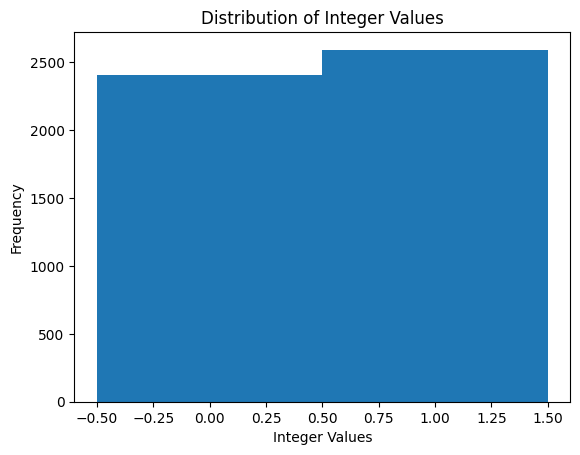

In [10]:
import matplotlib.pyplot as plt
result_labels = [int(num) for num in result_labels]

# Display the distribution of integer values
plt.hist(result_labels, bins=range(min(result_labels), max(result_labels) + 2), align='left')
plt.xlabel('Integer Values')
plt.ylabel('Frequency')
plt.title('Distribution of Integer Values')
plt.show()

In [ ]:
new_df = pd.DataFrame({
    'id': df['id'],
    'label': result_labels
})

# Exporting to a jsonl file
new_df.to_json('datasets/subtask_a_monolingual.jsonl', orient='records', lines=True)